# With fake data

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import aipy, uvtools
#from hera_sim import foregrounds, noise, sigchain, rfi
import h5py
import hera_cal
from collections import OrderedDict
import omnical
import time
from hera_cal.utils import AntennaArray
import cPickle as cp

In [2]:
Nants = 37

ants = np.loadtxt('antenna_positions_%d.dat'%Nants)
idxs = np.arange(Nants)
antpos = {}
for k,v in zip(idxs,ants):
    antpos[k] = v
    
redbls = hera_cal.redcal.get_pos_reds(antpos)

allbls = [bl for red in redbls for bl in red]
Malls = len(allbls)

subbls = [redbls[0],redbls[1],redbls[2]]
allsubs = [bl for red in subbls for bl in red]
Msubs = len(allsubs)

# Overall noise \propto 1/sqrt(N)
# For the shortest basesline set, the noise is 
# worse by a factor of np.sqrt(Malls/Msubs)
print np.sqrt(Malls/Msubs)

2.6457513110645907


In [3]:
fqs = np.linspace(.1,.2,num=1024,endpoint=False)
lsts = np.linspace(0,2*np.pi,100,endpoint=False)
times = lsts/(2*np.pi) * aipy.const.sidereal_day

In [4]:
hdr = OrderedDict(); vis = OrderedDict(); 
gains = OrderedDict(); wgts = OrderedDict()

with h5py.File('fake_vis.hdf5','r') as fp:
    for key in fp.keys():
        if (key.rfind('-')>0):
            a1,a2 = key.split('-')
            vis[(int(a1),int(a2))] = fp[key][...]
            wgts[(int(a1),int(a2))] = np.ones([len(lsts),len(fqs)])
        elif (key.startswith('g')):
            k = key.lstrip('g')
            gains[int(k)] = fp[key][...]
        else: hdr[key] = fp[key][...]

In [5]:
# Recompute input model visibilities 
# for comparision later
mdlvis = {}
for ant1,ant2 in vis.keys():
    mdlvis[(ant1,ant2)] = vis[(ant1,ant2)]/(gains[ant1] * gains[ant2].conj())

## Are the antennas redundant?

In [ ]:
# plt.figure()
# i = 1
# for pair in redbls[0]:
#     plt.subplot(5,6,i)
#     i += 1
#     plt.imshow(np.abs(mdlvis[pair]),aspect='auto',extent=[0,1024,0,10])
#     plt.axis('off')

## FirstCal

Get a rough sense of the delays between different antennas by considering all the frequency channels.

In [6]:
with open('fake_vis_sols_v5.cp','r') as fp:
    sols = cp.load(fp)

meta, gain_sols, vis_sols = sols

In [7]:
np.shape(gain_sols['x'][gain_sols['x'].keys()[0]])

(100, 1024)

In [8]:
with open('fake_vis_sub_sols_v5.cp','r') as fp:
    subset_sols = cp.load(fp)

submeta, subgain_sols, subvis_sols = subset_sols

In [9]:
with open('fake_vis_sub_sols.cp','r') as fp:
    subset_sols = cp.load(fp)

submeta_old, subgain_sols_old, subvis_sols_old = subset_sols

<IPython.core.display.Javascript object>


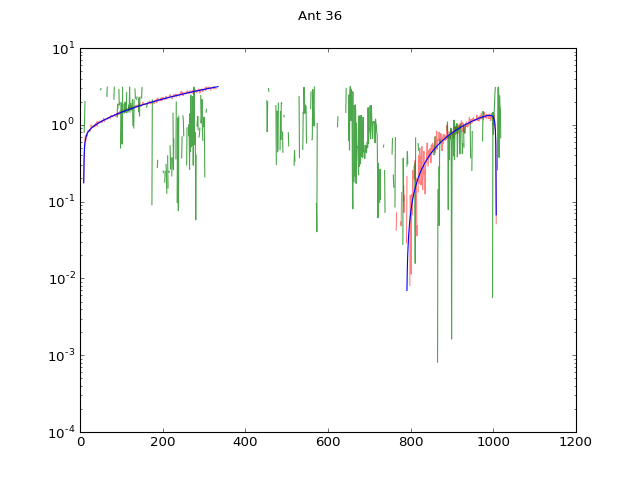

In [41]:
lst = 10

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(0,37):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    #ax.semilogy(np.abs(subgain_sols['x'][ant][lst]-gains[ant]),'g',label='New',alpha=0.7)
    #ax.semilogy(np.abs(subgain_sols_old['x'][ant][lst]-gains[ant]),'r',label='Old',alpha=0.5)
    ax.semilogy(np.angle(subgain_sols_old['x'][ant][lst]),'r',label='Old',alpha=0.5)
    ax.semilogy(np.angle(subgain_sols['x'][ant][lst]),'g',label='New',alpha=0.7)
    ax.semilogy(np.angle(gains[ant]),'b',label='Input value')
    #ax.set_ylim([1e-4,1e-1])
    time.sleep(1)
    fig.canvas.draw()

In [11]:
np.shape(subgain_sols['x'][subgain_sols['x'].keys()[0]][0:10])

(10, 1024)

<IPython.core.display.Javascript object>


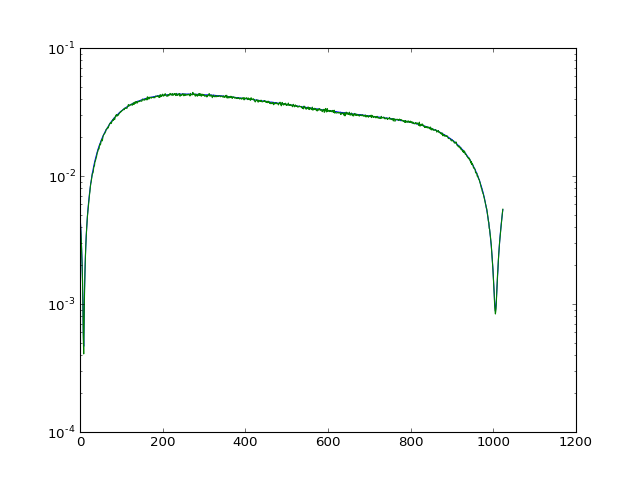

In [12]:
ant = 23
plt.figure()
plt.plot(np.mean(np.abs(gain_sols['x'][ant]),axis=0))
plt.plot(np.mean(np.abs(subgain_sols['x'][ant]),axis=0))

# Compare output and input

<IPython.core.display.Javascript object>


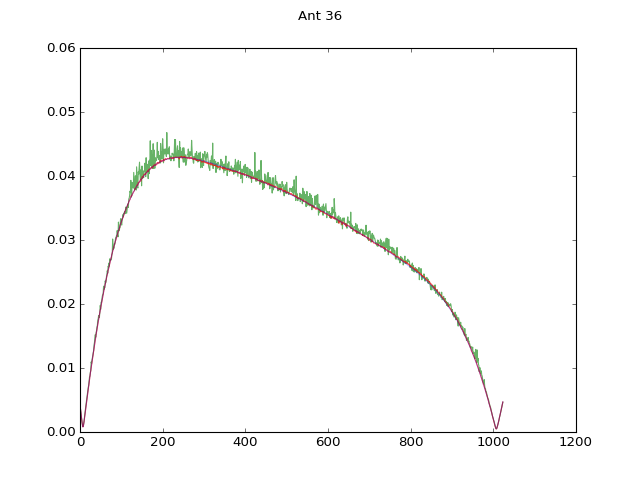

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for ant in range(0,37):
    fig.suptitle('Ant %d'%ant)
    ax.clear()
    ax.plot(np.mean(np.abs(subgain_sols['x'][ant]),axis=0),'g',label='Subset of ants',alpha=0.6)
    ax.plot(np.mean(np.abs(gain_sols['x'][ant]),axis=0),'r',label='All ants',alpha=0.7)
    ax.plot(np.abs(gains[ant]),'b',label='Input value',alpha=0.3)
    ax.set_ylim([0,.06])
    time.sleep(1)
    fig.canvas.draw()

In [31]:
lst = 25
mean_gain_comp = np.zeros([37,1024],dtype=np.float)
mean_gain_comp_lsts = np.zeros([37,1024],dtype=np.float)

for ant in range(0,37):
    mean_gain_comp_lsts[ant,:] = np.mean(np.abs(subgain_sols['x'][ant]),axis=0) - np.mean(np.abs(gain_sols['x'][ant]),axis=0)
    mean_gain_comp[ant,:] = np.abs(subgain_sols['x'][ant][lst]) - np.abs(gain_sols['x'][ant][lst])

In [32]:
np.sqrt(np.mean(mean_gain_comp**2,axis=1))

array([0.00367891, 0.00330835, 0.00681747, 0.00392565, 0.0040432 ,
       0.00287239, 0.00275066, 0.00372324, 0.00355074, 0.00554218,
       0.00353875, 0.00256989, 0.00272619, 0.00315491, 0.00342317,
       0.00343088, 0.00323809, 0.00254902, 0.00276304, 0.0025741 ,
       0.00357831, 0.00383451, 0.00344072, 0.00300312, 0.00263812,
       0.00263823, 0.0031815 , 0.00710256, 0.00317776, 0.00323886,
       0.00399081, 0.00328802, 0.00669356, 0.00357274, 0.00495265,
       0.00312673, 0.00419338])

<IPython.core.display.Javascript object>


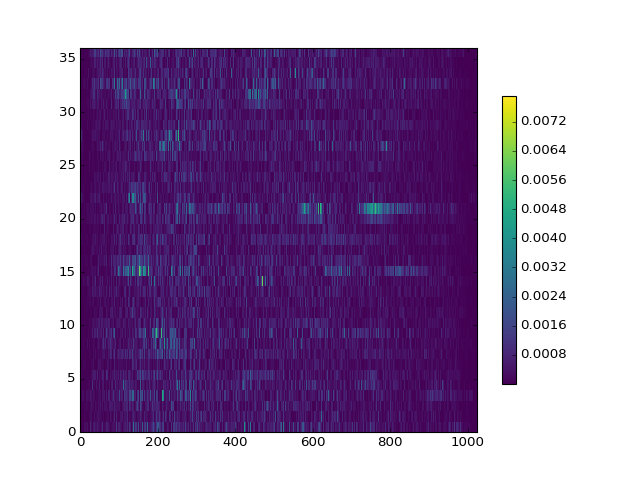

In [34]:
plt.figure()
plt.imshow(np.abs(mean_gain_comp_lsts),interpolation='nearest',
           extent=[0,1024,0,36],aspect='auto',cmap='viridis')
plt.colorbar(shrink=0.75)

<IPython.core.display.Javascript object>


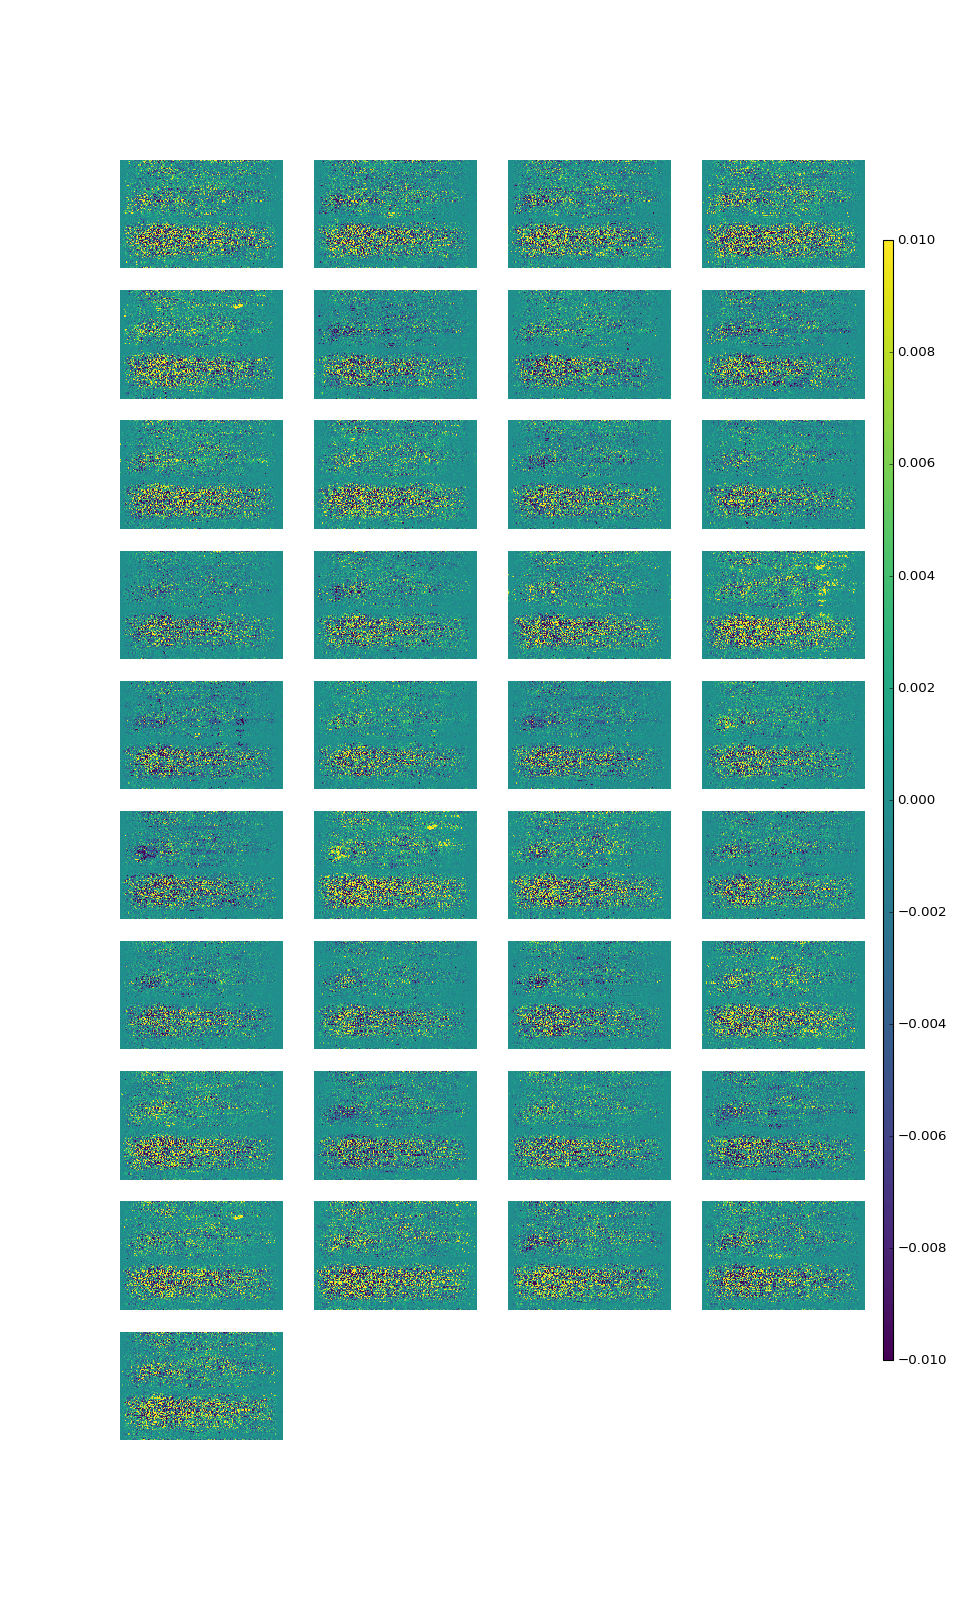

In [35]:
fig = plt.figure(figsize=(12,20))
for ant in range(0,37):
    plt.subplot(10,4,ant+1)
    ax = plt.imshow(np.abs(subgain_sols['x'][ant]) - np.abs(gain_sols['x'][ant]), vmin=-.01, vmax=.01,
                    interpolation='nearest',extent=[0,1024,0,100],aspect='auto',cmap='viridis')
    plt.axis('off')
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(ax,cax=cbar_ax)

# TO DO:

1. Does the noise match with measurements
2. Take the difference between the two methods

In [ ]:
ant = 20

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.ion()

fig.show()
fig.canvas.draw()

for lst in range(0,100):
    fig.suptitle('LST %d'%lst)
    ax1.clear(); ax2.clear()
    #ax.semilogy(np.abs(gains[ant]),'b',label='Input value')
    ax1.semilogy(np.abs(subgain_sols['x'][ant][lst]),label='Subset of ants')
    ax1.semilogy(np.abs(gain_sols['x'][ant][lst]),'r',label='All ants')
    ax1.set_ylim([1e-3,1e-1])
    
    ax2.semilogy(np.abs(subvis_sols['xx'][(0,5)][lst]),'r',label='Subset of ants')
    ax2.semilogy(np.abs(vis_sols['xx'][(0,5)][lst]),'g',label='All ants')
    ax2.semilogy(np.abs(mdlvis[(0,5)][lst]),'y',label='Input vis')
    
    time.sleep(1)
    fig.canvas.draw()

In [ ]:
x = np.abs(subgain_sols['x'][23][lst])/np.abs(gain_sols['x'][23][lst])
print np.log10(x).min(), np.log10(x).max()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for a1,a2 in subvis_sols['xx'].keys():
    fig.suptitle('(%d,%d)'%(a1,a2))
    ax.clear()
    
    if (a1,a2) in mdlvis.keys():
        ax.semilogy(np.abs(mdlvis[(a1,a2)][10]),'y',label='Input vis')    
    elif (a2,a1) in mdlvis.keys():
        ax.semilogy(np.abs(mdlvis[(a2,a1)][10]),'y',label='Input vis')
    
    if (a1,a2) in vis_sols['xx'].keys():
        ax.semilogy(np.abs(vis_sols['xx'][(a1,a2)][10]),'g',label='All ants')
    else:
        ax.semilogy(np.abs(vis_sols['xx'][(a2,a1)][10]),'g',label='All ants')
        
    ax.semilogy(np.abs(subvis_sols['xx'][(a1,a2)][10]),'r--',label='Subset of ants')
        
    time.sleep(1)
    fig.canvas.draw()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.ion()

# fig.show()
# fig.canvas.draw()

# for a1,a2 in subvis_sols['xx'].keys():
#     fig.suptitle('(%d,%d)'%(a1,a2))
#     ax.clear()
#     ax.plot(np.angle(subvis_sols['xx'][(a1,a2)][10]),'r--',label='Subset of ants')
#     if (a1,a2) in vis_sols['xx'].keys():
#         ax.plot(np.angle(vis_sols['xx'][(a1,a2)][10]),'g',label='All ants')
#     else:
#         ax.plot(np.angle(vis_sols['xx'][(a2,a1)][10]),'g',label='All ants')
#     if (a1,a2) in mdlvis.keys():
#         ax.plot(np.angle(mdlvis[(a1,a2)][10]),'y',label='Input vis')    
#     elif (a2,a1) in mdlvis.keys():
#         ax.plot(np.semilogy(mdlvis[(a2,a1)][10]),'y',label='Input vis')
#     else: print 'Not there'
        
#     time.sleep(1)
#     fig.canvas.draw() 